# A Sentiment Analysis of MLB Performance

In [1]:
#Install reqired libraries
!pip install beautifulsoup4 requests
!pip install tqdm

In [2]:
#Import required libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import numpy as np
import seaborn as sns

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm

##### The first step is to scrape the text from the blog posts from the mlbtraderumors.com website. The posts include text, dates posted, and the authors name, all of which will be scraped before storing into a dataframe to use and start the text analysis.

# Acquire Text Data

In [3]:
def scrape_website(url, file_path):
    #Send a GET request to the website
    response = requests.get(url)

    #Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    #Find all the news article elements
    articles = soup.find_all("article")

    #Create lists to store the extracted values
    titles = []
    authors = []
    dates = []
    contents = []

    #Iterate over the articles and extract the text
    with open(file_path, "w", encoding="utf-8") as file:
        for article in articles:
            #Extract the article title
            title_element = article.find("h2")
            title = title_element.text.strip() if title_element else ""
            titles.append(title)

            #Extract the article author
            author_element = article.find("span", class_="entry-author")
            author = author_element.text.strip() if author_element else ""
            authors.append(author)

            #Extract the article date
            date_element = article.find("time", class_="entry-time")
            date = date_element.text.strip() if date_element else ""
            dates.append(date)

            #Extract the article content
            content_element = article.find("div", class_="entry-content")
            content = content_element.text.strip() if content_element else ""
            contents.append(content)

            #Write the title and content to the file
            file.write("Title: " + title + "\n")
            file.write("Author: " + author + "\n")
            file.write("Date: " + date + "\n")
            file.write("Content: " + content + "\n")
            file.write("---\n")

    #Create a DataFrame from the extracted values
    data = {
        "Title": titles,
        "Author": authors,
        "Date": dates,
        "Content": contents
    }

    df = pd.DataFrame(data)

    #Drop rows without content
    df.dropna()

    return df

# Oakland Athletics Data Collection and Cleaning

In [4]:
#URL of the website to scrape
url = "https://www.mlbtraderumors.com/oakland-athletics?show=all"
file_path = "C:/Users/andre/OneDrive/Project/mlbtraderumors_oakland_athletics_articles1.txt"

#Scrape the website, write the scraped text to a file, and get the head of the DataFrame
oa_df = scrape_website(url, file_path)
oa_df.head()

,Title,Author,Date,Content
0,A’s Claim Angel Felipe,Steve Adams,"June 21, 2023",The Athletics have claimed right-hander Angel ...
1,Athletics Select Yacksel Ríos,Darragh McDonald,"June 20, 2023",The Athletics announced that they have selecte...
2,Dick Hall Passes Away,Darragh McDonald,"June 19, 2023",The Orioles have announced that former major l...
3,A’s Acquire Yacksel Rios,Nick Deeds,"June 18, 2023",6:56 PM: As noted by Justin Toscano of the Atl...
4,Report: Red Sox Interested In Aledmys Diaz,Mark Polishuk,"June 18, 2023",The Red Sox are looking to acquire an infielde...


In [5]:
#Change the Data column to a datetime object:
oa_df['Date'] = pd.to_datetime(oa_df['Date'], format="%B %d, %Y", errors= 'coerce')

In [6]:
oa_df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [7]:
#Check for missing values
oa_df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [8]:
len(oa_df)

1030

In [9]:
oa_df = oa_df.dropna()
oa_df

,Title,Author,Date,Content
0,A’s Claim Angel Felipe,Steve Adams,2023-06-21,The Athletics have claimed right-hander Angel ...
1,Athletics Select Yacksel Ríos,Darragh McDonald,2023-06-20,The Athletics announced that they have selecte...
2,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major l...
3,A’s Acquire Yacksel Rios,Nick Deeds,2023-06-18,6:56 PM: As noted by Justin Toscano of the Atl...
4,Report: Red Sox Interested In Aledmys Diaz,Mark Polishuk,2023-06-18,The Red Sox are looking to acquire an infielde...
...,...,...,...,...
995,"Forst: A's Expect Luzardo To Be ""A Factor"" Nex...",Steve Adams,2018-10-08,While some Athletics fans were hoping for a lo...
996,"A’s Notes: Davis, Melvin, Lucroy, Lowrie, Kelley",Mark Polishuk,2018-10-05,"After falling short in the AL wild card game, ..."
997,How Jonathan Lucroy Has Helped The A's,Mark Polishuk,2018-10-03,Jonathan Lucroy didn’t contribute much at the ...
998,A's To Start Liam Hendriks In Wild-Card Game,Connor Byrne,2018-10-02,The Yankees and Athletics have named their sta...


In [10]:
len(oa_df)

1000

## Import data on the Oakland Athletics from baseball-reference.com.

https://www.baseball-reference.com/teams/OAK/attend.shtml

In [11]:
#URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/OAK/attend.shtml"

#Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

#Select the table of interest (index 0 in this case)
table = tables[0]

#Save the DataFrame as a CSV file
file_path = "C:/Users/andre/OneDrive/Project/MLB_data/athletics_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/andre/OneDrive/Project/MLB_data/athletics_statistics.csv


In [12]:
path = "C:/Users/andre/OneDrive/Project/MLB_data/"

athletics_df = pd.DataFrame(pd.read_csv(path + 'athletics_statistics.csv'))
athletics_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,19,56,5,NaN,368146.0,9688.0,15th of 15,"$51,230,000",95,93,RingCentral Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,"$50,248,334",95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,"$94,555,834",95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,"$85,683,333",94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,"$102,935,833",93,94,Oakland-Alameda County Coliseum


In [13]:
athletics_df= athletics_df[athletics_df['Year'] > 2004]
athletics_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,19,56,5,NaN,368146.0,9688.0,15th of 15,"$51,230,000",95,93,RingCentral Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,"$50,248,334",95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,"$94,555,834",95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,"$85,683,333",94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,"$102,935,833",93,94,Oakland-Alameda County Coliseum
5,2018,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1573616.0,19427.0,13th of 15,"$69,883,333",97,97,Oakland-Alameda County Coliseum
6,2017,Oakland Athletics,AL West,75,87,5,NaN,1475721.0,18219.0,14th of 15,"$51,560,000",95,95,Oakland-Alameda County Coliseum
7,2016,Oakland Athletics,AL West,69,93,5,NaN,1521506.0,18784.0,14th of 15,"$54,969,067",97,96,Oakland-Alameda County Coliseum
8,2015,Oakland Athletics,AL West,68,94,5,NaN,1768175.0,21829.0,12th of 15,"$64,016,001",97,97,O.co Coliseum
9,2014,Oakland Athletics,AL West,88,74,2,Lost ALWC (1-0),2003628.0,24736.0,10th of 15,"$89,160,900",97,98,O.co Coliseum


In [14]:
#Remove the dollar and comma signs from the 'Estimated Payroll' column:
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].replace({'\$':''}, regex = True)
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].replace({'\,':''}, regex = True)
athletics_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Oakland Athletics,AL West,19,56,5,NaN,368146.0,9688.0,15th of 15,51230000,95,93,RingCentral Coliseum
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,50248334,95,93,RingCentral Coliseum
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,94555834,95,95,RingCentral Coliseum
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,85683333,94,96,Oakland-Alameda County Coliseum
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,102935833,93,94,Oakland-Alameda County Coliseum


In [15]:
athletics_df['Est. Payroll'] = athletics_df['Est. Payroll'].astype(float)
athletics_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

## Create Binary feature that defines a successful year as wins greater than or equal to 50% of total games played

In [16]:
#Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
athletics_df['success'] = (athletics_df['W'] / (athletics_df['W'] + athletics_df['L']) >= 0.5).astype(int)
athletics_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Oakland Athletics,AL West,19,56,5,NaN,368146.0,9688.0,15th of 15,51230000.0,95,93,RingCentral Coliseum,0
1,2022,Oakland Athletics,AL West,60,102,5,NaN,787902.0,9849.0,15th of 15,50248334.0,95,93,RingCentral Coliseum,0
2,2021,Oakland Athletics,AL West,86,76,3,NaN,701430.0,8660.0,15th of 15,94555834.0,95,95,RingCentral Coliseum,1
3,2020,Oakland Athletics,AL West,36,24,1,Lost ALDS (3-1),NaN,NaN,11th of 15,85683333.0,94,96,Oakland-Alameda County Coliseum,1
4,2019,Oakland Athletics,AL West,97,65,2,Lost ALWC (1-0),1670734.0,20626.0,10th of 15,102935833.0,93,94,Oakland-Alameda County Coliseum,1


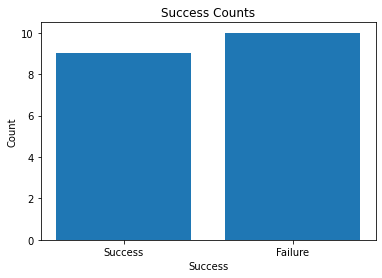

In [17]:
#Count the number of successes and failures
success_counts = athletics_df['success'].value_counts()

#Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

#Display the plot
plt.show()

In [18]:
athletics_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF,success
count,19.000000,19.000000,19.000000,19.000000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000,19.000000
mean,2014.000000,76.157895,75.842105,2.894737,1.518666e+06,19041.388889,6.754905e+07,96.157895,96.157895,0.526316
std,5.627314,20.456629,17.426873,1.523692,4.682565e+05,5114.775012,1.597226e+07,1.893356,2.061907,0.512989
min,2005.000000,19.000000,24.000000,1.000000,3.681460e+05,8660.000000,4.796713e+07,93.000000,93.000000,0.000000
25%,2009.500000,71.500000,67.000000,2.000000,1.432724e+06,17688.000000,5.519741e+07,95.000000,94.500000,0.000000
50%,2014.000000,76.000000,76.000000,3.000000,1.619436e+06,19993.000000,6.484308e+07,97.000000,96.000000,1.000000
75%,2018.500000,90.500000,87.000000,4.500000,1.799020e+06,22210.000000,7.462514e+07,97.000000,98.000000,1.000000
max,2023.000000,97.000000,102.000000,5.000000,2.109118e+06,26038.000000,1.029358e+08,100.000000,100.000000,1.000000


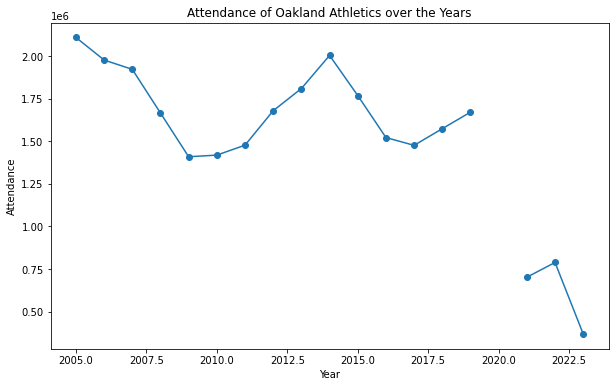

In [19]:
#Plotting the data
#Convert columns to numpy arrays
year = np.array(athletics_df['Year'])
attendance = np.array(athletics_df['Attendance'])

plt.figure(figsize=(10, 6))

#Plotting Attendance over the years
plt.plot(year, attendance, marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of Oakland Athletics over the Years')

#Display the plot
plt.show()

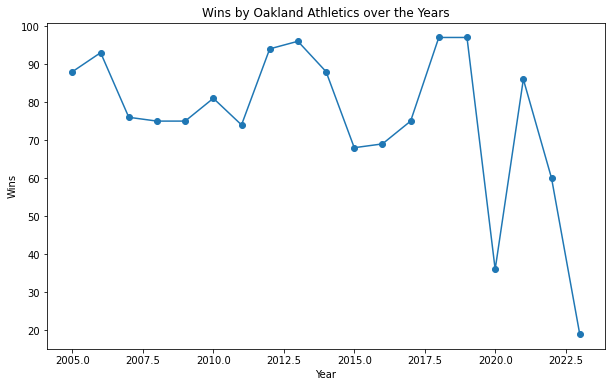

In [20]:
#Plotting Wins over the years
year = np.array(athletics_df['Year'])
wins = np.array(athletics_df['W'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, wins, marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins by Oakland Athletics over the Years')

#Display the plot
plt.show()

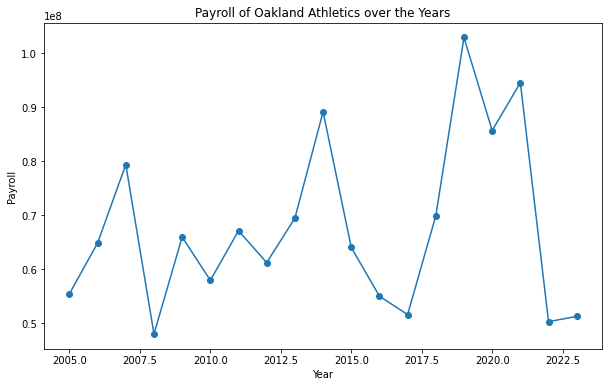

In [21]:
#Plotting Payroll over the years
#Convert columns to numpy arrays
year = np.array(athletics_df['Year'])
payroll = np.array(athletics_df['Est. Payroll'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, payroll, marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of Oakland Athletics over the Years')

#Display the plot
plt.show()

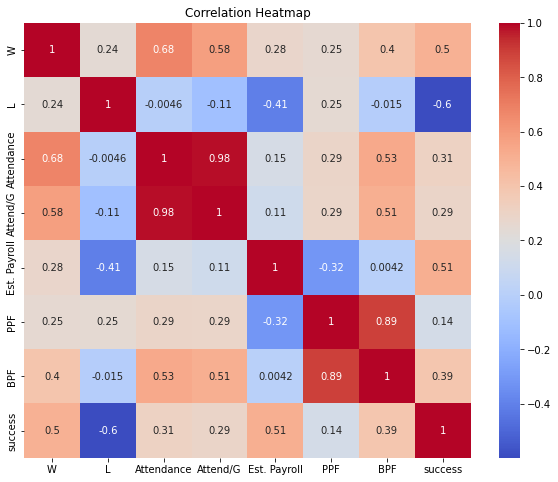

In [22]:
#Select numeric columns for correlation analysis
numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
numeric_df = athletics_df[numeric_cols]

#Correlation matrix
correlation = numeric_df.corr()

#Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

#Display the plot
plt.show()

#### Add column to analyze whether blog post occurred in a successful year or not.

In [23]:
#Extract the year from the "Date" column in df DataFrame
oa_df['Year'] = pd.to_datetime(oa_df['Date']).dt.year

#Merge df and athletics_df DataFrames on the "Year" column
merged_oa_df = pd.merge(oa_df, athletics_df[['Year', 'success']], on='Year', how='left')

#Add a new column 'Year_Successful' based on 'success' column
merged_oa_df['Year_Successful'] = merged_oa_df['success'].fillna(0).astype(int)

merged_oa_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,A’s Claim Angel Felipe,Steve Adams,2023-06-21,The Athletics have claimed right-hander Angel ...,2023,0,0
1,Athletics Select Yacksel Ríos,Darragh McDonald,2023-06-20,The Athletics announced that they have selecte...,2023,0,0
2,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major l...,2023,0,0
3,A’s Acquire Yacksel Rios,Nick Deeds,2023-06-18,6:56 PM: As noted by Justin Toscano of the Atl...,2023,0,0
4,Report: Red Sox Interested In Aledmys Diaz,Mark Polishuk,2023-06-18,The Red Sox are looking to acquire an infielde...,2023,0,0


In [24]:
len(merged_oa_df)

1000

# Cleaning the Data

In [25]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

In [26]:
merged_oa_df['Content'].apply

<bound method Series.apply of 0      The Athletics have claimed right-hander Angel ...
1      The Athletics announced that they have selecte...
2      The Orioles have announced that former major l...
3      6:56 PM: As noted by Justin Toscano of the Atl...
4      The Red Sox are looking to acquire an infielde...
                             ...                        
995    While some Athletics fans were hoping for a lo...
996    After falling short in the AL wild card game, ...
997    Jonathan Lucroy didn’t contribute much at the ...
998    The Yankees and Athletics have named their sta...
999    Sept. 28: The A’s announced tonight that Trigg...
Name: Content, Length: 1000, dtype: object>

In [27]:
pd.options.display.max_colwidth = 100 ###
#Add new column to data frame
merged_oa_df['impurity'] = merged_oa_df['Content'].apply(impurity, min_len=10)

#Get the top 3 records
merged_oa_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
113,"Major League Baseball’s international signing period for 2023 has officially opened up today, wi...",0.005563
946,Left-handed pitching prospect Jesus Luzardo is drawing raves from both inside and outside the At...,0.004474
533,Kingston fit the mold of many of the Angels’ candidates — well-regarded younger executives who w...,0.003306


##### The steps above displays the highest impurity levels for the Athletics' data set. The impurity levels above are extremely low, being below 1% of all characters in each blog post appear suspicious.

# Character Normalization and Tokenization

In [28]:
#Example function to normalize the text in the "Contents" column
def normalize_text(text):
    #Lowercase the text
    text = text.lower()

    #Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    #Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    #Tokenize the text
    tokens = word_tokenize(text)

    #Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    #Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

#Apply normalization to the "Contents" column
merged_oa_df["Contents_Normalized"] = merged_oa_df["Content"].apply(normalize_text)

#Print the head of the DataFrame with the normalized contents
merged_oa_df[["Content", "Contents_Normalized"]].head()
 	

,Content,Contents_Normalized
0,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...","[athlet, claim, righthand, angel, felip, waiver, padr, per, team, announc, felip, option, triple..."
1,The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...,"[athlet, announc, select, contract, righthand, yacksel, r, os, fellow, righti, chad, smith, opti..."
2,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...,"[oriol, announc, former, major, leaguer, dick, hall, pass, away, year, old, hall, underw, mani, ..."
3,"6:56 PM: As noted by Justin Toscano of the Atlanta Journal-Constitution, a clause in Rios’s pact...","[pm, note, justin, toscano, atlanta, journalconstitut, claus, rio, pact, brave, requir, club, ad..."
4,"The Red Sox are looking to acquire an infielder who can play multiple positions, MassLive.com’s ...","[red, sox, look, acquir, infield, play, multipl, posit, masslivecom, sean, mcadam, write, focu, ..."


In [29]:
merged_oa_df['length'] = merged_oa_df['Contents_Normalized'].str.len()
merged_oa_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...",2023,0,0,0.0,"[athlet, claim, righthand, angel, felip, waiver, padr, per, team, announc, felip, option, triple...",182
1,Athletics Select Yacksel Ríos,Darragh McDonald,2023-06-20,The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...,2023,0,0,0.0,"[athlet, announc, select, contract, righthand, yacksel, r, os, fellow, righti, chad, smith, opti...",179
2,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...,2023,0,0,0.0,"[oriol, announc, former, major, leaguer, dick, hall, pass, away, year, old, hall, underw, mani, ...",173
3,A’s Acquire Yacksel Rios,Nick Deeds,2023-06-18,"6:56 PM: As noted by Justin Toscano of the Atlanta Journal-Constitution, a clause in Rios’s pact...",2023,0,0,0.0,"[pm, note, justin, toscano, atlanta, journalconstitut, claus, rio, pact, brave, requir, club, ad...",206
4,Report: Red Sox Interested In Aledmys Diaz,Mark Polishuk,2023-06-18,"The Red Sox are looking to acquire an infielder who can play multiple positions, MassLive.com’s ...",2023,0,0,0.0,"[red, sox, look, acquir, infield, play, multipl, posit, masslivecom, sean, mcadam, write, focu, ...",84


# Analyze descriptive statistics for text in dataframe.

<Axes: >

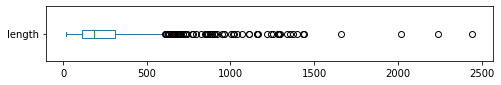

In [30]:
merged_oa_df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: >

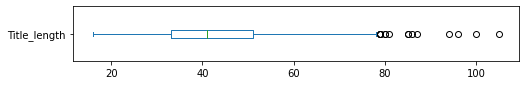

In [31]:
merged_oa_df['Title_length'] = merged_oa_df['Title'].str.len()
merged_oa_df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: ylabel='Frequency'>

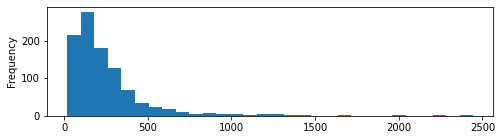

In [32]:
merged_oa_df['length'].plot(kind='hist', bins=30, figsize=(8,2))

<Axes: title={'center': 'Avg. Post Length'}, xlabel='Month'>

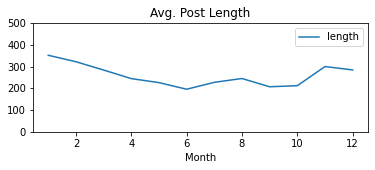

In [33]:
#Extract the month from the date and create a new column
merged_oa_df['Month'] = merged_oa_df['Date'].dt.month

#Plot the average post length
merged_oa_df.groupby('Month').agg({'length': 'mean'}) \
  .plot(title="Avg. Post Length", ylim=(0,500), figsize=(6,2))


In [34]:
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    #Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    #Create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    #Transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [35]:
freq_df = count_words(merged_oa_df)
freq_df.head(5)

,freq
token,
season,3189
year,2292
leagu,1837
mm,1595
oakland,1570


In [36]:
#How many tokens are in the df?
len(freq_df)

6654

In [37]:
#Top words with 10+ characters
count_words(merged_oa_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)

,freq
token,
appearances,733
organization,374
arbitration,368
outfielder,316
assignment,272


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

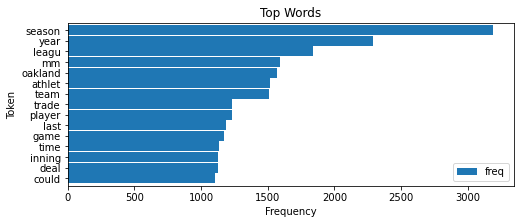

In [38]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# Chicago White Sox Data Collection and Cleaning

In [39]:
#URL of the website to scrape
url = "https://www.mlbtraderumors.com/chicago-white-sox?show=all"
file_path = "C:/Users/andre/OneDrive/Project/mlbtraderumors_chicago_white_sox_articles1.txt"

#Scrape the website, write the scraped text to a file, and get the head of the DataFrame
cws_df = scrape_website(url, file_path)
cws_df.head()

,Title,Author,Date,Content
0,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,"June 21, 2023","Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ..."
1,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,"June 21, 2023","The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w..."
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,"June 20, 2023","The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno..."
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,"June 19, 2023",The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,"June 16, 2023","The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ..."


In [40]:
#change the Date column to a datetime object:
cws_df['Date'] = pd.to_datetime(cws_df['Date'], format="%B %d, %Y", errors= 'coerce')

In [41]:
cws_df.dtypes

Title              object
Author             object
Date       datetime64[ns]
Content            object
dtype: object

In [42]:
cws_df.isna().sum()

Title       0
Author      0
Date       30
Content     0
dtype: int64

In [43]:
len(cws_df)

1030

In [44]:
cws_df = cws_df.dropna()
cws_df

,Title,Author,Date,Content
0,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,2023-06-21,"Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ..."
1,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,2023-06-21,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w..."
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,2023-06-20,"The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno..."
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,2023-06-19,The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,2023-06-16,"The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ..."
...,...,...,...,...
995,White Sox Outright Dustin Garneau,Connor Byrne,2018-10-02,"The White Sox have outrighted catcher Dustin Garneau to Triple-A Charlotte, Daryl Van Schouwen o..."
996,Rick Hahn On White Sox’ Offseason Plans,Jeff Todd,2018-09-27,White Sox GM Rick Hahn addressed the media yesterday regarding the state of his organization’s r...
997,Avisail Garcia To Undergo Knee Surgery,Jeff Todd,2018-09-25,"White Sox outfielder Avisail Garcia is set to undergo right knee surgery, he told reporters incl..."
998,"Past, Present & Future: American League Closer Turnover",Jason Martinez,2018-09-25,"By the end of the 2017 season, the list of pitchers closing out games for their respective teams..."


In [45]:
len(cws_df)

1000

## Import data on the Chicago White Sox from baseball-reference.com.

https://www.baseball-reference.com/teams/CHW/attend.shtml

In [46]:
#URL of the webpage to scrape
url = "https://www.baseball-reference.com/teams/CHW/attend.shtml"

#Read the HTML table into a list of DataFrames
tables = pd.read_html(url)

#Select the table of interest (index 0 in this case)
table = tables[0]

#Save the DataFrame as a CSV file
file_path = "C:/Users/andre/OneDrive/Project/MLB_data/white_sox_statistics.csv"
table.to_csv(file_path, index=False, header=True)

print("Data saved to", file_path)

Data saved to C:/Users/andre/OneDrive/Project/MLB_data/white_sox_statistics.csv


In [47]:
path = "C:/Users/andre/OneDrive/Project/MLB_data/"

white_sox_df = pd.DataFrame(pd.read_csv(path + 'white_sox_statistics.csv'))
white_sox_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Chicago White Sox,AL Central,32,43,4,NaN,679077.0,18863.0,11th of 15,"$157,571,666",104,104,Guaranteed Rate Field
1,2022,Chicago White Sox,AL Central,81,81,2,NaN,2009359.0,24807.0,8th of 15,"$163,958,334",103,103,Guaranteed Rate Field
2,2021,Chicago White Sox,AL Central,93,69,1,Lost ALDS (3-1),1596385.0,19708.0,5th of 15,"$115,546,333",101,102,Guaranteed Rate Field
3,2020,Chicago White Sox,AL Central,35,25,3,Lost ALWC (2-1),NaN,NaN,3rd of 15,"$119,066,333",100,100,Guaranteed Rate Field
4,2019,Chicago White Sox,AL Central,72,89,3,NaN,1649775.0,20622.0,11th of 15,"$80,846,333",99,98,Guaranteed Rate Field


In [48]:
white_sox_df= white_sox_df[white_sox_df['Year'] > 2004]
white_sox_df

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Chicago White Sox,AL Central,32,43,4,NaN,679077.0,18863.0,11th of 15,"$157,571,666",104,104,Guaranteed Rate Field
1,2022,Chicago White Sox,AL Central,81,81,2,NaN,2009359.0,24807.0,8th of 15,"$163,958,334",103,103,Guaranteed Rate Field
2,2021,Chicago White Sox,AL Central,93,69,1,Lost ALDS (3-1),1596385.0,19708.0,5th of 15,"$115,546,333",101,102,Guaranteed Rate Field
3,2020,Chicago White Sox,AL Central,35,25,3,Lost ALWC (2-1),NaN,NaN,3rd of 15,"$119,066,333",100,100,Guaranteed Rate Field
4,2019,Chicago White Sox,AL Central,72,89,3,NaN,1649775.0,20622.0,11th of 15,"$80,846,333",99,98,Guaranteed Rate Field
5,2018,Chicago White Sox,AL Central,62,100,4,NaN,1608817.0,19862.0,12th of 15,"$75,092,000",99,98,Guaranteed Rate Field
6,2017,Chicago White Sox,AL Central,67,95,4,NaN,1629470.0,20117.0,13th of 15,"$97,842,000",98,97,Guaranteed Rate Field
7,2016,Chicago White Sox,AL Central,78,84,4,NaN,1746293.0,21559.0,12th of 15,"$113,416,000",96,96,U.S. Cellular Field
8,2015,Chicago White Sox,AL Central,76,86,4,NaN,1755810.0,21677.0,13th of 15,"$112,889,700",97,96,U.S. Cellular Field
9,2014,Chicago White Sox,AL Central,73,89,4,NaN,1650821.0,20381.0,13th of 15,"$87,475,500",98,97,U.S. Cellular Field


In [49]:
#Remove the dollar sign from the 'Estimated Payroll' column:
white_sox_df['Est. Payroll'] = white_sox_df['Est. Payroll'].replace({'\$':''}, regex = True)
white_sox_df['Est. Payroll'] = white_sox_df['Est. Payroll'].replace({'\,':''}, regex = True)
white_sox_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium
0,2023,Chicago White Sox,AL Central,32,43,4,NaN,679077.0,18863.0,11th of 15,157571666,104,104,Guaranteed Rate Field
1,2022,Chicago White Sox,AL Central,81,81,2,NaN,2009359.0,24807.0,8th of 15,163958334,103,103,Guaranteed Rate Field
2,2021,Chicago White Sox,AL Central,93,69,1,Lost ALDS (3-1),1596385.0,19708.0,5th of 15,115546333,101,102,Guaranteed Rate Field
3,2020,Chicago White Sox,AL Central,35,25,3,Lost ALWC (2-1),NaN,NaN,3rd of 15,119066333,100,100,Guaranteed Rate Field
4,2019,Chicago White Sox,AL Central,72,89,3,NaN,1649775.0,20622.0,11th of 15,80846333,99,98,Guaranteed Rate Field


In [50]:
white_sox_df['Est. Payroll'] = white_sox_df['Est. Payroll'].astype(float)
white_sox_df.dtypes

Year              int64
Tm               object
Lg               object
W                 int64
L                 int64
Finish            int64
Playoffs         object
Attendance      float64
Attend/G        float64
Rank             object
Est. Payroll    float64
PPF               int64
BPF               int64
Stadium          object
dtype: object

### Create Binary feature that defines a successful year as wins greater than or equal to 50% of total games played

In [51]:
#Add a column to define a binary output that has a 1 if the team has a winning record for the year, and 0 if they do not
white_sox_df['success'] = (white_sox_df['W'] / (white_sox_df['W'] + white_sox_df['L']) >= 0.5).astype(int)
white_sox_df.head()

,Year,Tm,Lg,W,L,Finish,Playoffs,Attendance,Attend/G,Rank,Est. Payroll,PPF,BPF,Stadium,success
0,2023,Chicago White Sox,AL Central,32,43,4,NaN,679077.0,18863.0,11th of 15,157571666.0,104,104,Guaranteed Rate Field,0
1,2022,Chicago White Sox,AL Central,81,81,2,NaN,2009359.0,24807.0,8th of 15,163958334.0,103,103,Guaranteed Rate Field,1
2,2021,Chicago White Sox,AL Central,93,69,1,Lost ALDS (3-1),1596385.0,19708.0,5th of 15,115546333.0,101,102,Guaranteed Rate Field,1
3,2020,Chicago White Sox,AL Central,35,25,3,Lost ALWC (2-1),NaN,NaN,3rd of 15,119066333.0,100,100,Guaranteed Rate Field,1
4,2019,Chicago White Sox,AL Central,72,89,3,NaN,1649775.0,20622.0,11th of 15,80846333.0,99,98,Guaranteed Rate Field,0


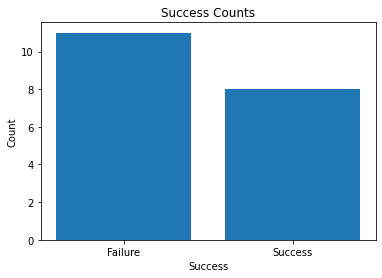

In [52]:
#Count the number of successes and failures
success_counts = white_sox_df['success'].value_counts()

#Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

#Display the plot
plt.show()

In [53]:
white_sox_df.describe()

,Year,W,L,Finish,Attendance,Attend/G,Est. Payroll,PPF,BPF,success
count,19.000000,19.000000,19.000000,19.00000,1.800000e+01,18.000000,1.900000e+01,19.000000,19.000000,19.000000
mean,2014.000000,74.368421,77.684211,3.00000,1.945840e+06,24598.166667,1.087984e+08,101.789474,101.473684,0.421053
std,5.627314,17.493524,18.508414,1.20185,5.110815e+05,5122.477425,2.436409e+07,3.137213,3.372576,0.507257
min,2005.000000,32.000000,25.000000,1.00000,6.790770e+05,18863.000000,7.509200e+07,96.000000,96.000000,0.000000
25%,2009.500000,69.500000,73.000000,2.00000,1.650036e+06,20441.250000,9.265875e+07,99.000000,98.000000,0.000000
50%,2014.000000,78.000000,83.000000,3.00000,1.867184e+06,23051.500000,1.086718e+08,103.000000,103.000000,0.000000
75%,2018.500000,86.500000,89.000000,4.00000,2.261717e+06,27922.750000,1.186372e+08,104.000000,104.000000,1.000000
max,2023.000000,99.000000,100.000000,5.00000,2.957414e+06,36511.000000,1.639583e+08,106.000000,106.000000,1.000000


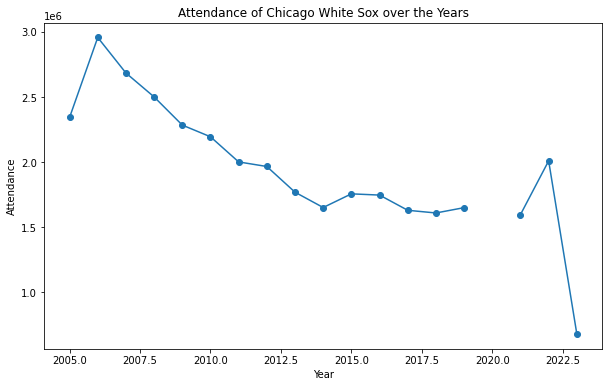

In [54]:
#Plotting
#Convert columns to numpy arrays
year = np.array(white_sox_df['Year'])
attendance = np.array(white_sox_df['Attendance'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, attendance, marker='o')
plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Attendance of Chicago White Sox over the Years')

#Display the plot
plt.show()

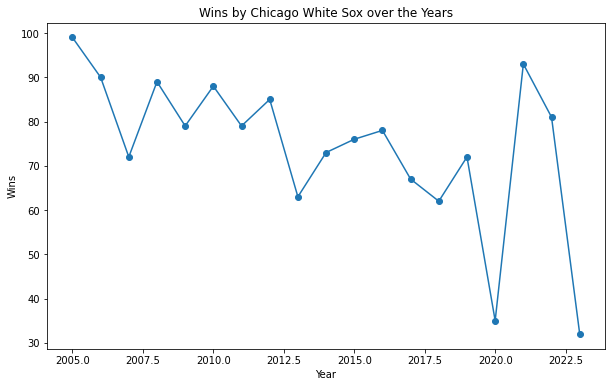

In [55]:
#Plotting Wins over the years
#Convert columns to numpy arrays
year = np.array(white_sox_df['Year'])
wins = np.array(white_sox_df['W'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, wins, marker='o')
plt.xlabel('Year')
plt.ylabel('Wins')
plt.title('Wins by Chicago White Sox over the Years')

#Display the plot
plt.show()

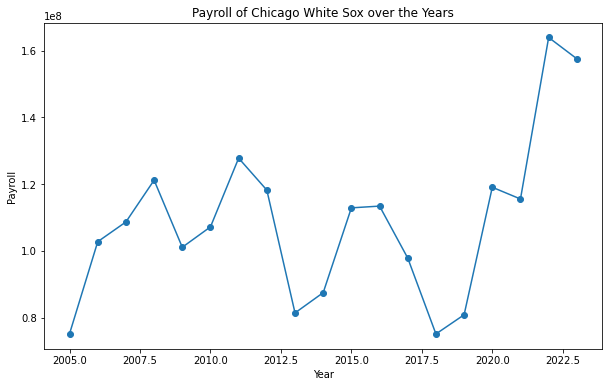

In [56]:
#Plotting Payroll over the years
#Convert columns to numpy arrays
year = np.array(white_sox_df['Year'])
payroll = np.array(white_sox_df['Est. Payroll'])

plt.figure(figsize= (10,6))

#Plotting Attendance over the years
plt.plot(year, payroll, marker='o')
plt.xlabel('Year')
plt.ylabel('Payroll')
plt.title('Payroll of Chicago White Sox over the Years')

#Display the plot
plt.show()

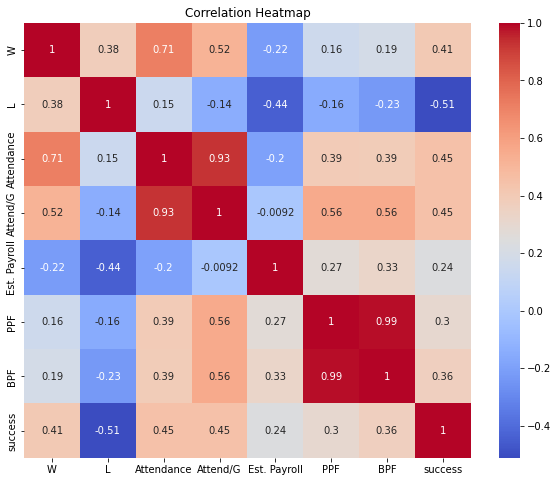

In [57]:
# Select numeric columns for correlation analysis
numeric_cols = ['W', 'L', 'Attendance', 'Attend/G', 'Est. Payroll', 'PPF', 'BPF', 'success']
numeric_df = white_sox_df[numeric_cols]

# Correlation matrix
correlation = numeric_df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

# Display the plot
plt.show()

In [58]:
#Extract the year from the "Date" column in df DataFrame
cws_df['Year'] = pd.to_datetime(cws_df['Date']).dt.year

#Merge df and white_sox_df DataFrames on the "Year" column
merged_ws_df = pd.merge(cws_df, white_sox_df[['Year', 'success']], on='Year', how='left')

#Add a new column 'Year_Successful' based on 'success' column
merged_ws_df['Year_Successful'] = merged_ws_df['success'].fillna(0).astype(int)

merged_ws_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful
0,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,2023-06-21,"Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ...",2023,0,0
1,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,2023-06-21,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...",2023,0,0
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,2023-06-20,"The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno...",2023,0,0
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,2023-06-19,The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...,2023,0,0
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,2023-06-16,"The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ...",2023,0,0


In [59]:
len(merged_ws_df)

1000

## Cleaning the Data

In [60]:
#Identify any noise in the data
RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)


In [61]:
merged_ws_df['Content'].apply

<bound method Series.apply of 0      Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ...
1      The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...
2      The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno...
3      The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...
4      The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ...
                                                      ...                                                 
995    The White Sox have outrighted catcher Dustin Garneau to Triple-A Charlotte, Daryl Van Schouwen o...
996    White Sox GM Rick Hahn addressed the media yesterday regarding the state of his organization’s r...
997    White Sox outfielder Avisail Garcia is set to undergo right knee surgery, he told reporters incl...
998    

In [62]:
pd.options.display.max_colwidth = 100 ###
#Add new column to data frame
merged_ws_df['impurity'] = merged_ws_df['Content'].apply(impurity, min_len=10)

#Get the top 3 records
merged_ws_df[['Content', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

,Content,impurity
333,"The White Sox aren’t planning to make any coaching changes, manager Tony La Russa told Daryl Van...",0.003578
875,Eloy Jimenez’s career-opening extension with the White Sox included “an understanding” that Jime...,0.002797
450,"Adam Engel will begin the season the injured list, as White Sox manager Tony La Russa told repor...",0.002782


The steps above displays the highest impurity levels for the White Sox's data set. The impurity levels above are extremely low, being below 1% of all characters in each blog post appear suspicious.

# Character Normalization and Tokenization

In [63]:
#Example function to normalize the text in the "Contents" column
def normalize_text(text):
    #Lowercase the text
    text = text.lower()

    #Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    #Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)

    #Tokenize the text
    tokens = word_tokenize(text)

    #Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    #Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens


In [64]:
#Apply normalization to the "Contents" column
merged_ws_df["Contents_Normalized"] = merged_ws_df["Content"].apply(normalize_text)

#Print the head of the DataFrame with the normalized contents
merged_ws_df[["Content", "Contents_Normalized"]].head()

,Content,Contents_Normalized
0,"Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ...","[twin, outfield, byron, buxton, dealt, mani, injuri, throughout, career, led, twin, use, exclus,..."
1,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...","[latest, episod, mlb, trade, rumor, podcast, live, spotifi, appl, podcast, wherev, get, podcast,..."
2,"The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno...","[white, sox, claim, righthand, touki, toussaint, waiver, guardian, per, announc, club, design, a..."
3,The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...,"[white, sox, announc, hand, transact, tonight, seri, open, ranger, notabl, recal, infield, prosp..."
4,"The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ...","[white, sox, place, starter, mike, cleving, day, injur, list, retroact, june, due, bicep, inflam..."


In [65]:
merged_ws_df['length'] = merged_ws_df['Contents_Normalized'].str.len()
merged_ws_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length
0,"AL Central Notes: Buxton, Crochet, Tigers",Darragh McDonald,2023-06-21,"Twins outfielder Byron Buxton has dealt with many injuries throughout his career, which has led ...",2023,0,0,0.0,"[twin, outfield, byron, buxton, dealt, mani, injuri, throughout, career, led, twin, use, exclus,...",377
1,"MLBTR Trade Rumors Podcast: Exciting Youth Movements in Cincinnati and Pittsburgh, Bad Central D...",Darragh McDonald,2023-06-21,"The latest episode of the MLB Trade Rumors Podcast is now live on Spotify, Apple Podcasts, and w...",2023,0,0,0.0,"[latest, episod, mlb, trade, rumor, podcast, live, spotifi, appl, podcast, wherev, get, podcast,...",124
2,White Sox Claim Touki Toussaint From Guardians,Darragh McDonald,2023-06-20,"The White Sox have claimed right-hander Touki Toussaint off waivers from the Guardians, per anno...",2023,0,0,0.0,"[white, sox, claim, righthand, touki, toussaint, waiver, guardian, per, announc, club, design, a...",143
3,White Sox Recall Jose Rodriguez For MLB Debut,Anthony Franco,2023-06-19,The White Sox announced a handful of transactions before tonight’s series opener with the Ranger...,2023,0,0,0.0,"[white, sox, announc, hand, transact, tonight, seri, open, ranger, notabl, recal, infield, prosp...",165
4,White Sox Place Mike Clevinger On Injured List,Anthony Franco,2023-06-16,"The White Sox placed starter Mike Clevinger on the 15-day injured list, retroactive to June 15, ...",2023,0,0,0.0,"[white, sox, place, starter, mike, cleving, day, injur, list, retroact, june, due, bicep, inflam...",229


# Analyze descriptive statistics for text in dataframe.

<Axes: >

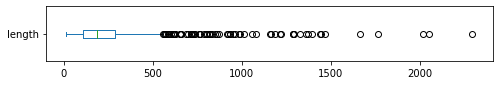

In [66]:
merged_ws_df['length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: >

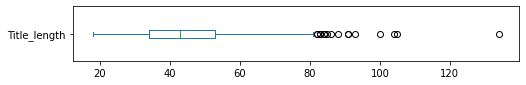

In [67]:
merged_ws_df['Title_length'] = merged_ws_df['Title'].str.len()
merged_ws_df['Title_length'].plot(kind='box', vert=False, figsize=(8, 1))

<Axes: ylabel='Frequency'>

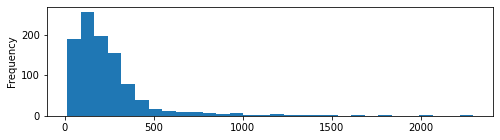

In [68]:
merged_ws_df['length'].plot(kind='hist', bins=30, figsize=(8,2))

In [69]:
# Extract the month from the date and create a new column
merged_ws_df['Month'] = merged_ws_df['Date'].dt.month

<Axes: title={'center': 'Avg. Post Length'}, xlabel='Month'>

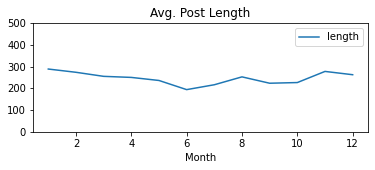

In [70]:
# Plot the average post length
merged_ws_df.groupby('Month').agg({'length': 'mean'}) \
  .plot(title="Avg. Post Length", ylim=(0,500), figsize=(6,2))

In [71]:
def count_words(df, column='Contents_Normalized', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    tqdm.pandas() #initialize tqdm for progress bar
    df[column].apply(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)


In [72]:
freq_df = count_words(merged_ws_df)
freq_df.head(5)

,freq
token,
sox,3881
season,3077
white,2872
year,2174
mm,1970


In [73]:
#How many tokens are in the df?
len(freq_df)

6278

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

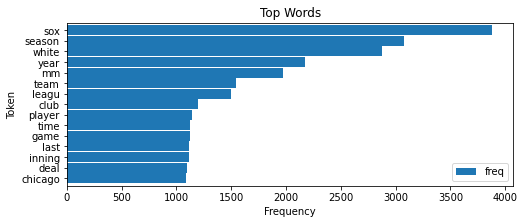

In [74]:
# top words with 10+ characters
count_words(merged_ws_df, column='Content', 
            preprocess=lambda Content: re.findall(r"\w{10,}", Content)).head(5)


ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# Combine both merged team data into one dataframe for further analysis and modeling.

In [75]:
comb_df = pd.concat([merged_oa_df, merged_ws_df], ignore_index= True)
len(comb_df)

2000

In [76]:
comb_df.head()

,Title,Author,Date,Content,Year,success,Year_Successful,impurity,Contents_Normalized,length,Title_length,Month
0,A’s Claim Angel Felipe,Steve Adams,2023-06-21,"The Athletics have claimed right-hander Angel Felipe off waivers from the Padres, per a team ann...",2023,0,0,0.0,"[athlet, claim, righthand, angel, felip, waiver, padr, per, team, announc, felip, option, triple...",182,22,6
1,Athletics Select Yacksel Ríos,Darragh McDonald,2023-06-20,The Athletics announced that they have selected the contract of right-hander Yacksel Ríos. Fello...,2023,0,0,0.0,"[athlet, announc, select, contract, righthand, yacksel, r, os, fellow, righti, chad, smith, opti...",179,29,6
2,Dick Hall Passes Away,Darragh McDonald,2023-06-19,The Orioles have announced that former major leaguer Dick Hall has passed away. He was 92 years ...,2023,0,0,0.0,"[oriol, announc, former, major, leaguer, dick, hall, pass, away, year, old, hall, underw, mani, ...",173,21,6
3,A’s Acquire Yacksel Rios,Nick Deeds,2023-06-18,"6:56 PM: As noted by Justin Toscano of the Atlanta Journal-Constitution, a clause in Rios’s pact...",2023,0,0,0.0,"[pm, note, justin, toscano, atlanta, journalconstitut, claus, rio, pact, brave, requir, club, ad...",206,24,6
4,Report: Red Sox Interested In Aledmys Diaz,Mark Polishuk,2023-06-18,"The Red Sox are looking to acquire an infielder who can play multiple positions, MassLive.com’s ...",2023,0,0,0.0,"[red, sox, look, acquir, infield, play, multipl, posit, masslivecom, sean, mcadam, write, focu, ...",84,42,6


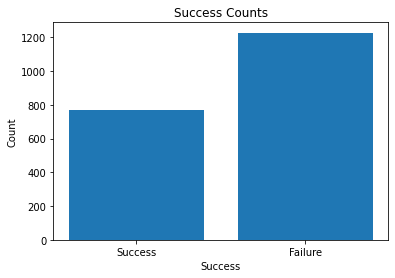

In [77]:
# Count the number of successes and failures
success_counts = comb_df['success'].value_counts()

# Create a bar plot
plt.bar(success_counts.index, success_counts.values)
plt.xticks(success_counts.index, ['Failure', 'Success'])
plt.xlabel('Success')
plt.ylabel('Count')
plt.title('Success Counts')

# Display the plot
plt.show()

# Modeling

## Logistic Regression Modeling

In [78]:
!pip install scikit-learn

  Using cached scikit_learn-1.2.2-cp38-cp38-win_amd64.whl (8.3 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)


In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [80]:
X_train, X_test, y_train, y_test = train_test_split(comb_df['Content'], comb_df['success'], test_size=0.2, random_state=42)

In [81]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [82]:
model = LogisticRegression()
model.fit(X_train_vec, y_train)

LogisticRegression()

In [83]:
y_pred = model.predict(X_test_vec)

In [84]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.78


## Penalized Logistic Regression

In [85]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

In [86]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=5)
grid_search.fit(X_train_vec, y_train)

best_C = grid_search.best_params_['C']

In [87]:
model = LogisticRegression(penalty='l2', C=best_C)
model.fit(X_train_vec, y_train)

LogisticRegression(C=10)

In [88]:
y_pred = model.predict(X_test_vec)

In [89]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.8175
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       156
           1       0.82      0.89      0.86       244

    accuracy                           0.82       400
   macro avg       0.82      0.80      0.80       400
weighted avg       0.82      0.82      0.81       400



In [90]:
coefficients = model.coef_
print(coefficients)

[[-0.39092491 -0.04871666 -0.16233833 ... -0.3033715  -0.11903213
  -0.35938319]]


In [91]:
# Retrieve feature names from vectorizer
feature_names = vectorizer.get_feature_names_out()

# Calculate feature importance
feature_importance = np.abs(model.coef_[0])

# Sort feature importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

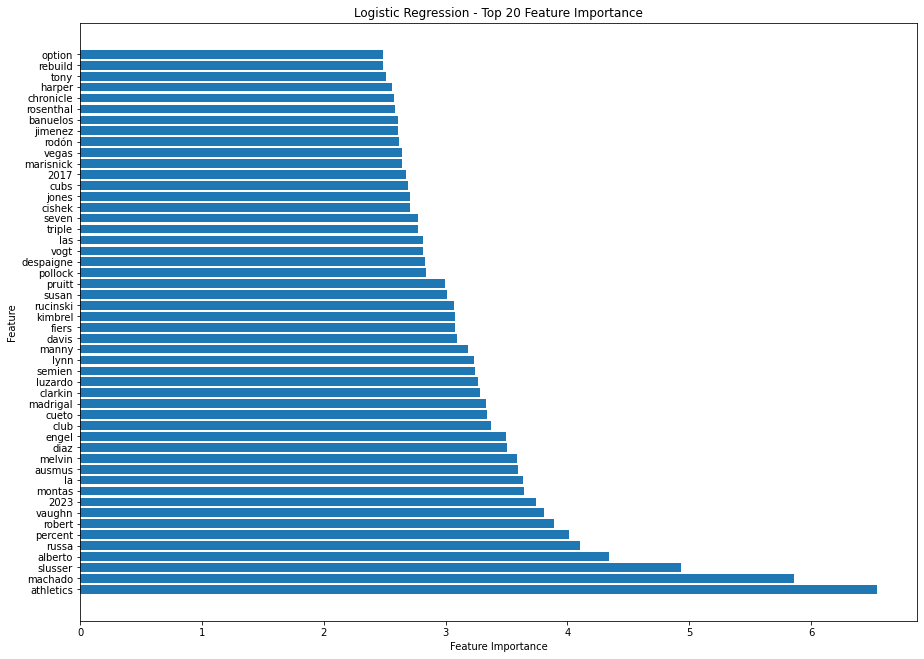

In [92]:
# Select top 20 features
top_feature_importance = sorted_feature_importance[:50]
top_feature_names = sorted_feature_names[:50]

# Plot top 20 feature importance
plt.figure(figsize=(15, 11))
plt.barh(range(len(top_feature_names)), top_feature_importance, align='center')
plt.yticks(range(len(top_feature_names)), top_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Logistic Regression - Top 20 Feature Importance')
plt.show()